# Imports

In [17]:
#!pip install sklearn-som 
#!pip install beecolpy
import random as rn
from numpy.random import choice as np_choice
import time
import random as rand
import numpy as np
import pandas as pd
import math
from math import sqrt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn_som.som import SOM
from scipy import stats
import matplotlib.pyplot as plt
from random import sample, randint
from sklearn.decomposition import PCA
from bidi.algorithm import get_display
import arabic_reshaper
from beecolpy import abc
from sklearn import metrics
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering


def fa(text):
    return get_display(arabic_reshaper.reshape(u'%s' % str(text)))

# load dataset

In [3]:
df = pd.read_csv('./dataset.csv',header=None)
df.columns = ['user', 'movie', 'rate', 'timestamp']
df.head()

,user,movie,rate,timestamp
0,1,61,4,878542420
1,1,189,3,888732928
2,1,33,4,878542699
3,1,160,4,875072547
4,1,20,4,887431883


In [4]:
user_number = df['user'].max()
movie_number = df['movie'].max()
print(f'shape : {df.shape}')
print(f'Number of user : {user_number}')
print(f'Number of movie : {movie_number}')

shape : (100000, 4)
Number of user : 943
Number of movie : 1682


# Train and Test split

In [5]:
train, test = train_test_split(df, test_size=0.20, random_state=0)
print(f'Train shape : {train.shape}')
print(f'Test shape : {test.shape}')

Train shape : (80000, 4)
Test shape : (20000, 4)


# Convertor function

In [6]:
def convert2R(df):
    R = np.zeros((user_number, movie_number),dtype=float)
    for index , row in df.iterrows():
        R[row['user']-1, row['movie']-1] = row['rate']
    return R

# Some basic calculation

In [7]:
matrix = convert2R(train)

 d = 311


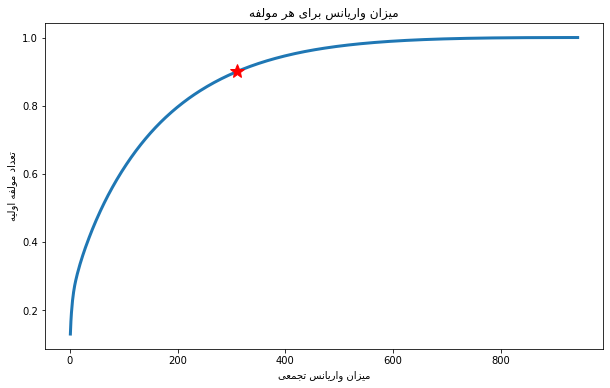

In [8]:
pca = PCA(n_components=user_number)
pca.fit_transform(matrix)
cumsum = pca.explained_variance_ratio_.cumsum()
d = np.where(cumsum>=0.9)[0][0] + 1
print(f' d = {d}')

plt.figure(figsize=(10,6))
plt.plot(range(1,len(cumsum)+1), cumsum, linewidth=3)
plt.plot(d, cumsum[d-1],'r*',markersize=15)
plt.title(fa('میزان واریانس برای هر مولفه'))
plt.xlabel(fa('میزان واریانس تجمعی'))
plt.ylabel(fa('تعداد مولفه اولیه'))
plt.show()

In [9]:
pca = PCA(n_components=d)
pca_matrix = pca.fit_transform(matrix)
print(pca_matrix.shape)

(943, 311)


In [10]:
# calc means for all user
means = np.zeros(user_number)
for i in range(0,user_number):
    means[i] = matrix[i,:][matrix[i,:]>0].mean() 

In [11]:
# mean center
mean_centered = []
for i in range(0,user_number):
    mean_centered.append(pd.Series(matrix[i,:]).apply(lambda x : 0 if x == 0 else x - means[i]))

In [12]:
# mean center pow2
mean_center_pow2 = []
for i in range(0,user_number):
    mean_center_pow2.append(sqrt(mean_centered[i].apply(lambda x : x**2).sum()))

In [13]:
# calc Sim for all user                        
Sims = np.zeros((user_number,user_number))
for i in range(0,user_number):
    for j in range(i,user_number):        
        Sims[i,j]  = sum(mean_centered[i] * mean_centered[j]) / (mean_center_pow2[i] *  mean_center_pow2[j])        
        Sims[j,i] = Sims[i,j] 
    print(i,end='\r')

# Result calculation

In [14]:
LABELS = [fa('امتیاز پایین'),fa('امتیاز بالا')]    
def confusion_matrix(tp,fp,tn,fn):            
    matrix = np.array([[tn, fp], [fn, tp]], np.int32)
    # freq
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,cmap="Reds",linecolor='white',linewidths=1,
                xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt="d")    
    plt.title(fa('ماتریس درهم‌ریختگی'))
    plt.ylabel(fa('پاسخ'))
    plt.xlabel(fa('تخمین'))
    plt.show()
    
    # percentage
    sensitivity =  np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100    
    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(sensitivity,cmap="Reds",linecolor='white',linewidths=1,
                xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt=".2f")    
    
    for t in ax.texts: t.set_text(t.get_text() + " %")
    plt.title(fa('ماتریس درهم‌ریختگی'))
    plt.ylabel(fa('پاسخ'))
    plt.xlabel(fa('تخمین'))
    plt.show()

In [15]:
def getResult(pred, threshold = 3.5):
    # variables    
    counter = 0
    mae = 0    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    # for all test values
    for index, row in test.iterrows():     
        p = pred(row) # predict value
        t = row['rate'] # true value        
        mae += abs(t - p)        
        if(t >= threshold):
            if(p >= threshold):
                tp += 1
            else:
                fn += 1             
        else:
            if(p >= threshold):
                fp += 1
            else:
                tn += 1            
        counter += 1
        print(counter,end='\r')
    print("",end='\r\r')
    mae /= test.shape[0]
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * recall) / (precision + recall) 
    confusion_matrix(tp,fp,tn,fn)
    return [recall, precision, f1, mae]

# Hierarchical clustering

20000

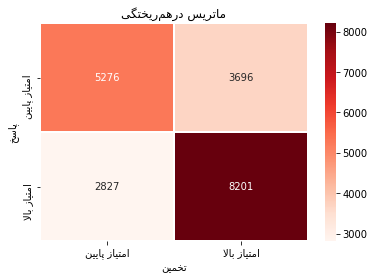

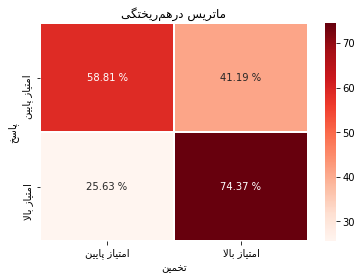

for k = 5
recall : 0.7436525208560029
precision : 0.689333445406405
f1 : 0.71546346782988
MAE : 0.798351210625546


In [19]:
k = 5
agg_clustering = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'ward')
 
labels = agg_clustering.fit_predict(matrix)

def pred(row): 
    # find neighbors for this user
    u = row['user'] - 1     
    t = row['movie'] - 1    
    neighbors = np.where(labels == labels[u])[0].tolist()            
    neighbors.remove(u)    
    # if there is no neighbor return 0 
    if(len(neighbors) == 0):
        return 0
    # calc
    a = 0 
    b = 0
    for n in neighbors:
        s = Sims[u,n]       
        if(matrix[n,t] != 0):
            a += s * ( matrix[n,t]- means[n])
        b += abs(s)            
    return means[u] + a / b
[recall, precision, f1, mae] = getResult(pred)
print(f'for k = {k}')
print(f'recall : {recall}')
print(f'precision : { precision}')
print(f'f1 : { f1}')
print(f'MAE : { mae}')

# K-means clustring

20000

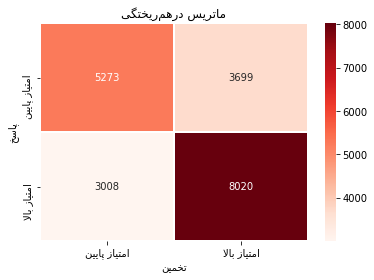

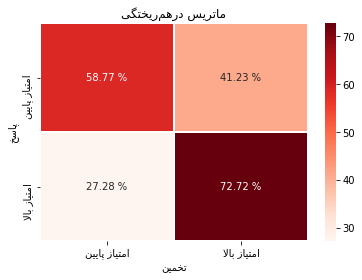

for k = 1
recall : 0.7272397533550962
precision : 0.6843587336803482
f1 : 0.7051479315953753
MAE : 0.8130216822549804


In [80]:
k = 1
kmeans = KMeans(n_clusters=k, random_state=0).fit(matrix)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

def pred(row): 
    # find neighbors for this user
    u = row['user'] - 1     
    t = row['movie'] - 1    
    neighbors = np.where(labels == labels[u])[0].tolist()            
    neighbors.remove(u)    
    # if there is no neighbor return 0 
    if(len(neighbors) == 0):
        return 0
    # calc
    a = 0 
    b = 0
    for n in neighbors:
        s = Sims[u,n]       
        if(matrix[n,t] != 0):
            a += s * ( matrix[n,t]- means[n])
        b += abs(s)            
    return means[u] + a / b
[recall, precision, f1, mae] = getResult(pred)
print(f'for k = {k}')
print(f'recall : {recall}')
print(f'precision : { precision}')
print(f'f1 : { f1}')
print(f'MAE : { mae}')

# PCA K-means

In [15]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(pca_matrix)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

def pred(row): 
    # find neighbors for this user
    u = row['user'] - 1     
    t = row['movie'] - 1    
    neighbors = np.where(labels == labels[u])[0].tolist()            
    neighbors.remove(u)    
    # if there is no neighbor return 0 
    if(len(neighbors) == 0):
        return 0
    # calc
    a = 0 
    b = 0
    for n in neighbors:
        s = Sims[u,n]       
        if(matrix[n,t] != 0):
            a += s * ( matrix[n,t]- means[n])
        b += abs(s)            
    return means[u] + a / b
[recall, precision, f1, mae] = getResult(pred)
print(f'for k = {k}')
print(f'recall : {recall}')
print(f'precision : { precision}')
print(f'f1 : { f1}')
print(f'MAE : { mae}')

for k = 5
recall : 0.7427457381211462
precision : 0.6898846121452034
f1 : 0.7153399414872713
MAE : 0.7978677503618622


# SOM

In [16]:
k = 5
som = SOM(m=k, n=1, dim=movie_number)
som.fit(matrix)
labels = som.predict(matrix)

def pred(row): 
    # find neighbors for this user
    u = row['user'] - 1     
    t = row['movie'] - 1    
    neighbors = np.where(labels == labels[u])[0].tolist()            
    neighbors.remove(u)    
    # if there is no neighbor return 0 
    if(len(neighbors) == 0):
        return 0
    # calc
    a = 0 
    b = 0
    for n in neighbors:
        s = Sims[u,n]       
        if(matrix[n,t] != 0):
            a += s * ( matrix[n,t]- means[n])
        b += abs(s)            
    return means[u] + a / b
[recall, precision, f1, mae] = getResult(pred)
print(f'for k = {k}')
print(f'recall : {recall}')
print(f'precision : { precision}')
print(f'f1 : { f1}')
print(f'MAE : { mae}')

for k = 5
recall : 0.7406601378309757
precision : 0.6887015177065767
f1 : 0.7137364557846908
MAE : 0.7980218995900825


# PCA-SOM

In [17]:
k = 5
som = SOM(m=k, n=1, dim=d)
som.fit(pca_matrix)
labels = som.predict(pca_matrix)

def pred(row): 
    # find neighbors for this user
    u = row['user'] - 1     
    t = row['movie'] - 1    
    neighbors = np.where(labels == labels[u])[0].tolist()            
    neighbors.remove(u)    
    # if there is no neighbor return 0 
    if(len(neighbors) == 0):
        return 0
    # calc
    a = 0 
    b = 0
    for n in neighbors:
        s = Sims[u,n]       
        if(matrix[n,t] != 0):
            a += s * ( matrix[n,t]- means[n])
        b += abs(s)            
    return means[u] + a / b
[recall, precision, f1, mae] = getResult(pred)
print(f'for k = {k}')
print(f'recall : {recall}')
print(f'precision : { precision}')
print(f'f1 : { f1}')
print(f'MAE : { mae}')

for k = 5
recall : 0.7441059122234313
precision : 0.6896377846877889
f1 : 0.7158372224887687
MAE : 0.7979318389543154


# GA-KM

In [44]:
def genetic_algorithm(k, data, maxIt = 200, nPop = 50, pCrossover = 0.7, pMutation = 0.2 ):        
    d = data.shape[1]
    VarMin = 0  # Lower Bound 
    VarMax = 5  # Upper Bound     
    
    def cost_function(solution):    
        errors = np.zeros((k,user_number),dtype= float)
        for i in range(0,k):            
            errors[i,:] = ((solution[i,:] - data)**2).sum(axis=1)**0.5                
        return sum(errors.min(axis=0))
    
    def crossover(sol1,sol2):        
        point = sample(range(1,d-1),1)[0]    
        out1 = sol1.copy()
        out2 = sol2.copy()
        out1[:,0:point] = sol2[:,0:point]
        out2[:,0:point] = sol1[:,0:point]
        return out1, out2
    
    def mutation(solution):
        [k , d] = solution.shape
        out = solution.copy()
        out[randint(0,k-1), randint(0,d-1)] = np.random.uniform(VarMin, VarMax, 1)[0]
        return out
    
    # init population
    nCrossover = int(np.round(pCrossover * nPop))  # Number of crossover    
    nMutation = int(np.round(pMutation * nPop))  # Number of Mutants
    solutions = []
    costs = []
    for i in range(0,nPop):
        solutions.append(np.random.uniform(VarMin, VarMax, (k,d)))
        costs.append(cost_function(solutions[i]))    
    # sort population         
    index = np.argsort(costs)
    costs = [costs[i] for i in index]
    solutions = [solutions[i] for i in index]        
    # store Best Solution    
    bestCost = np.zeros([maxIt, 1])        
    # GA Main Loop
    for it in range(1,maxIt+1):
        # Crossover             
        for _ in range(0, nCrossover):
            sols = sample(range(0,nPop),2)                        
            [sol1, sol2] = crossover(solutions[sols[0]], solutions[sols[1]])    
            solutions.append(sol1)
            solutions.append(sol2)
            costs.append(cost_function(sol1))
            costs.append(cost_function(sol2))
        # Mutation                
        for _ in range(0,nMutation):                  
            sol = mutation(solutions[randint(0, nPop - 1)])
            solutions.append(sol)
            costs.append(cost_function(sol))                            
        # sort
        index = np.argsort(costs)
        costs = [costs[i] for i in index]
        costs = [costs[i] for i in range(0,nPop)] # only select nPop from population
        solutions = [solutions[i] for i in index]     
        solutions = [solutions[i] for i in range(0,nPop)] # only select nPop from population
        # store Best Solution
        bestCost[it-1] = costs[0]        
        print(f"iteration {it} BestCost is: {bestCost[it-1]}")        
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(0,maxIt), bestCost)
    plt.title("Best Cost in each iteration")
    plt.ylabel("Best Cost")
    plt.xlabel("Iterations")
    plt.show()
    return solutions[0]

iteration 1 BestCost is: [106597.04644859]
iteration 2 BestCost is: [106144.38383826]
iteration 3 BestCost is: [106144.38383826]
iteration 4 BestCost is: [105753.92714834]
iteration 5 BestCost is: [105647.92939431]
iteration 6 BestCost is: [105287.84398478]
iteration 7 BestCost is: [105197.83170818]
iteration 8 BestCost is: [104726.49996648]
iteration 9 BestCost is: [104183.08582026]
iteration 10 BestCost is: [104063.83519262]


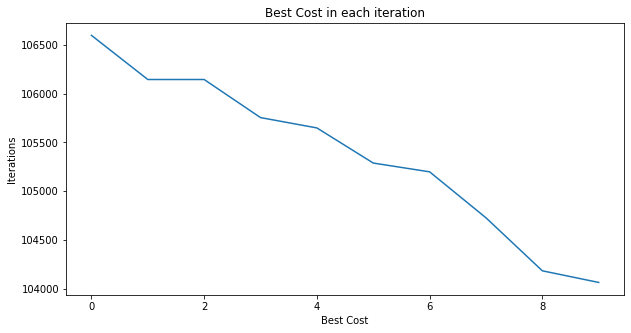

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


for k = 5
recall : 0.7219804134929271
precision : 0.6836682122617208
f1 : 0.7023021963482403
MAE : 0.826603376529639


In [42]:
k = 5
sol = genetic_algorithm(5,matrix)
kmeans = KMeans(n_clusters=k,init=sol).fit(matrix)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

def pred(row): 
    # find neighbors for this user
    u = row['user'] - 1     
    t = row['movie'] - 1    
    neighbors = np.where(labels == labels[u])[0].tolist()            
    neighbors.remove(u)    
    # if there is no neighbor return 0 
    if(len(neighbors) == 0):
        return 0
    # calc
    a = 0 
    b = 0
    for n in neighbors:
        s = Sims[u,n]       
        if(matrix[n,t] != 0):
            a += s * ( matrix[n,t]- means[n])
        b += abs(s)            
    return means[u] + a / b
[recall, precision, f1, mae] = getResult(pred)
print(f'for k = {k}')
print(f'recall : {recall}')
print(f'precision : { precision}')
print(f'f1 : { f1}')
print(f'MAE : { mae}')

# PCA GA-KM

iteration 1 BestCost is: [51117.72577877]
iteration 2 BestCost is: [50925.7471142]
iteration 3 BestCost is: [50925.7471142]
iteration 4 BestCost is: [50925.7471142]
iteration 5 BestCost is: [50925.7471142]
iteration 6 BestCost is: [50726.68870867]
iteration 7 BestCost is: [50691.31034856]
iteration 8 BestCost is: [50691.18082608]
iteration 9 BestCost is: [50691.18082608]
iteration 10 BestCost is: [50691.18082608]
iteration 11 BestCost is: [50590.27427796]
iteration 12 BestCost is: [50499.46437412]
iteration 13 BestCost is: [50448.72634164]
iteration 14 BestCost is: [50377.37942218]
iteration 15 BestCost is: [50296.0352352]
iteration 16 BestCost is: [50296.0352352]
iteration 17 BestCost is: [50000.63498835]
iteration 18 BestCost is: [49981.10533432]
iteration 19 BestCost is: [49981.10533432]
iteration 20 BestCost is: [49981.10533432]
iteration 21 BestCost is: [49827.53863839]
iteration 22 BestCost is: [49827.53863839]
iteration 23 BestCost is: [49676.79292347]
iteration 24 BestCost is: 

iteration 191 BestCost is: [44710.04679496]
iteration 192 BestCost is: [44710.04679496]
iteration 193 BestCost is: [44710.04679496]
iteration 194 BestCost is: [44710.04679496]
iteration 195 BestCost is: [44568.37525045]
iteration 196 BestCost is: [44555.27328133]
iteration 197 BestCost is: [44555.27328133]
iteration 198 BestCost is: [44413.06905557]
iteration 199 BestCost is: [44413.06905557]
iteration 200 BestCost is: [44410.04152226]


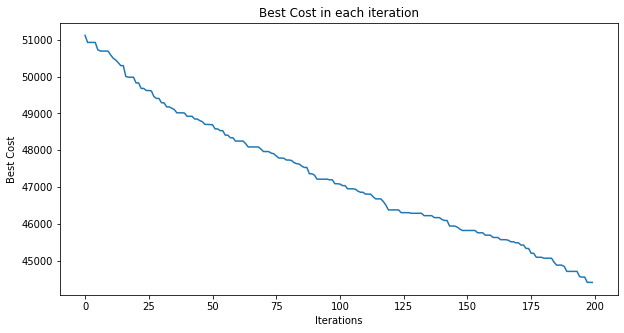

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


for k = 5
recall : 0.7070184983677911
precision : 0.6841874341874342
f1 : 0.695415626114877
MAE : 0.8736928526497361


In [45]:
k = 5
sol = genetic_algorithm(5,pca_matrix)
kmeans = KMeans(n_clusters=k,init=sol).fit(pca_matrix)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

def pred(row): 
    # find neighbors for this user
    u = row['user'] - 1     
    t = row['movie'] - 1    
    neighbors = np.where(labels == labels[u])[0].tolist()            
    neighbors.remove(u)    
    # if there is no neighbor return 0 
    if(len(neighbors) == 0):
        return 0
    # calc
    a = 0 
    b = 0
    for n in neighbors:
        s = Sims[u,n]       
        if(matrix[n,t] != 0):
            a += s * ( matrix[n,t]- means[n])
        b += abs(s)            
    return means[u] + a / b
[recall, precision, f1, mae] = getResult(pred)
print(f'for k = {k}')
print(f'recall : {recall}')
print(f'precision : { precision}')
print(f'f1 : { f1}')
print(f'MAE : { mae}')

# ABC-KM

In [70]:
k = 5
d = movie_number
def cost_function(solution):                
    errors = np.zeros((k,user_number),dtype= float)
    for i in range(0,k):            
        errors[i,:] = ((solution[(i*d):((i*d)+d)] - matrix)**2).sum(axis=1)**0.5                
    return sum(errors.min(axis=0))
    
boundaries = [(1,5) for i in range(k * d)]
abc_obj = abc(cost_function,
              boundaries,
              colony_size=40,
              scouts=0.5,
              iterations=200,
              min_max='min',
              nan_protection=True,
              log_agents=True)
abc_obj.fit()
solution = abc_obj.get_solution()
solution = np.reshape(solution, (k, d))

kmeans = KMeans(n_clusters=k,init=solution).fit(matrix)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

def pred(row): 
    # find neighbors for this user
    u = row['user'] - 1     
    t = row['movie'] - 1    
    neighbors = np.where(labels == labels[u])[0].tolist()            
    neighbors.remove(u)    
    # if there is no neighbor return 0 
    if(len(neighbors) == 0):
        return 0
    # calc
    a = 0 
    b = 0
    for n in neighbors:
        s = Sims[u,n]       
        if(matrix[n,t] != 0):
            a += s * ( matrix[n,t]- means[n])
        b += abs(s)            
    return means[u] + a / b
[recall, precision, f1, mae] = getResult(pred)
print(f'for k = {k}')
print(f'recall : {recall}')
print(f'precision : { precision}')
print(f'f1 : { f1}')
print(f'MAE : { mae}')

[4.0777518072337955,
 3.6634937586852923,
 3.0096774131630912,
 3.924172905092402,
 4.455181608459134,
 4.851997911941313,
 4.1144486027637,
 2.790015731338337,
 2.6068785401969157,
 2.0177503588778274,
 1.2839877802716155,
 4.1880660346531124,
 1.9832434146975784,
 2.5859287464748726,
 3.025480441302994,
 4.455190750708795,
 1.1170315733368485,
 4.213123264687347,
 2.742393874958651,
 3.6462553645261346,
 3.1695433453197395,
 1.0662741856693607,
 3.4939451317841743,
 2.8438831619741114,
 2.4509710921276375,
 3.331385328514176,
 3.704851946780379,
 1.6294541942396341,
 3.366497224236715,
 3.50406234275763,
 4.534918087471766,
 1.5678159375499843,
 3.885737420530816,
 4.478832982077896,
 2.245128168989675,
 2.7548435823641864,
 4.796655462072803,
 2.9352387849234476,
 1.5475925514023463,
 3.1116183699492104,
 2.7668896465180377,
 3.8215205621317447,
 3.9440649540887875,
 1.6785168447609649,
 1.6580054539017488,
 3.259217164599321,
 2.748124919787969,
 2.2028856760944224,
 2.179657140870

# ACO-KM

## https://github.com/Akavall/AntColonyOptimization

In [81]:
distances = np.zeros((user_number,user_number),dtype=float)
for i in range(user_number):
    di = matrix[i,:].copy()    
    di[di!= 0] = 1        
    for j in range(i,user_number):
        if(i==j):
            distances[i,j] = np.inf
        else:     
            dj = matrix[j,:].copy()    
            dj[dj!= 0] = 1
            d = ((matrix[i,:]- matrix[j,:])**2).sum()**0.5
            #d = (((matrix[i,:]- matrix[j,:])*di*dj)**2).sum() / (di*dj).sum()
            if(math.isnan(d)):
                d = np.inf
            if(d==0):
                d = np.finfo(float).eps
            distances[i,j] = d
            distances[j,i] = d
    print(i, end='\r')

In [115]:
class AntColony(object):
    def __init__(self,k,kmeans_result, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):        
        self.distances  = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        g = self.pheromone        
        for i in range(0,k-1):
            self.pheromone[kmeans_result[i],kmeans_result[i+1]] = 1                        
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.k = k

    def run(self):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])            
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path            
            self.pheromone = self.pheromone * self.decay            
        return all_time_shortest_path

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for i in range(distances.shape[0]):        
            m = []
            for p in path:                
                m.append(self.distances[i,p[0]])                                    
            total_dist += min(m)                
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(np.random.randint(user_number))
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        #for i in range(len(self.distances) - 1):
        for i in range(0,self.k):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        #path.append((prev, start)) # going back to where we started    
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)

        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move

20000

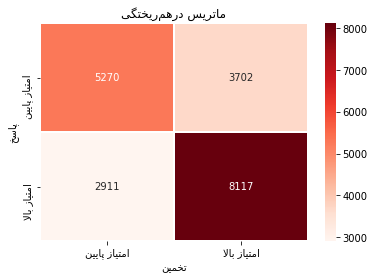

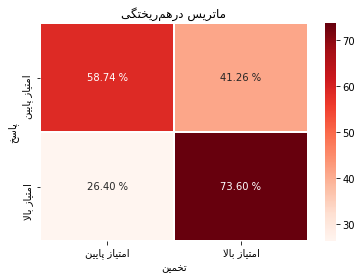

for k = 5
recall : 0.7360355458832064
precision : 0.6867755309247822
f1 : 0.710552807808465
MAE : 0.8065189659810121


In [114]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(matrix)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
## calc reslut 
result = []
for c in centers:
    m = np.zeros((user_number,1),dtype=float)
    for i in range(user_number):            
        m[i] =  ((matrix[i,:] - c)**2).sum()**0.5
    result.append(np.argmin(m))
##
ant_colony = AntColony(k,result, distances, 100, 10, 200, 0.95, alpha=1, beta=1)
shortest_path = ant_colony.run()
shortest_path = [p[0]for p in shortest_path[0]]
shortest_path

for u in range(user_number):
    d = np.zeros((k,1),dtype=float)    
    i = 0
    for c in shortest_path:
        d[i] = ((matrix[u,:] - matrix[c,:])**2).sum()**0.5
        i += 1    
    labels[u] = np.argmin(d)

def pred(row): 
    # find neighbors for this user
    u = row['user'] - 1     
    t = row['movie'] - 1    
    neighbors = np.where(labels == labels[u])[0].tolist()            
    neighbors.remove(u)    
    # if there is no neighbor return 0 
    if(len(neighbors) == 0):
        return 0
    # calc
    a = 0 
    b = 0
    for n in neighbors:
        s = Sims[u,n]       
        if(matrix[n,t] != 0):
            a += s * ( matrix[n,t]- means[n])
        b += abs(s)            
    return means[u] + a / b
[recall, precision, f1, mae] = getResult(pred)
print(f'for k = {k}')
print(f'recall : {recall}')
print(f'precision : { precision}')
print(f'f1 : { f1}')
print(f'MAE : { mae}')